In [1]:
import pandas as pd
import numpy as np
import math

# This has, at the end Euler Discretization Scheme. Note that if n is too big we cannot compute more psi**n..

### Set Free Parameters

Note this is a particular case. We chose epsilon high, and r_max low, because the coefficients are increasing. And after some point, python cannot compute them anymore as they go to inf. That's why r_max is low and epsilon high

In [2]:
alpha = 0.64
lambd = 0.045
mu = -64.938
nu = 44850

# error measures
epsilon = 0.01
theta = 0.9

# Let's set r_max, so that we compute the first r_max coefficients
r_max = 105

### This function returns the list of coefficients

In [3]:
def returns_all_the_first_r_max_coefficients_as_list_2():
    ''' Run this function. This returns the list of coefficients. Up to a_k where 
        k= r_max. '''
    
    coefficients = [np.nan]*(r_max+1)

    a0 = 0 
    a1 = nu/math.gamma(alpha+1)
    coefficients[0] = a0
    coefficients[1] = a1
    
    
    def recursive_convol_coefficients(list_of_coefficients, k):
        ''' return a*_k^2  given the first k-1 a_m coefficients. 
        k is the coefficient a^_k^2 to be returned'''
        if k==1:
            return 0
        else: 
            sum = 0
            for l in range(1,k):
                a_l = list_of_coefficients[l]
                a_k_l = list_of_coefficients[k-l]
                sum += a_l*a_k_l
            return sum
    
    
    def recursive_coefficients(list_of_coefficients, n):
        ''' Given the convoluted coefficient a_k_star_quadro, 
        Given also n, the coefficient a_n to be returned... Note that n = k+1 !!! 
        returns a_k'''
        k = n-1 # n-1 = k
        a_k_star_quadro = recursive_convol_coefficients(list_of_coefficients, k) 
        a_k = list_of_coefficients[k]  
        a_n = (lambd*a_k_star_quadro + mu*a_k)*math.gamma(alpha*k + 1)/math.gamma(alpha*k + alpha + 1)
    
        return a_n

    for i in range(2, r_max+1):
        coefficients[i] = recursive_coefficients( coefficients, i)
        
    return coefficients

In [4]:
coeff = returns_all_the_first_r_max_coefficients_as_list_2()
#coeff

In [5]:
### Poi posso stampare in un dataframe e metterlo nella tesi i risultati/ coefficienti

In [6]:
len(coeff)

106

### Estimating the radius of convergence

In [7]:
coeff

[0,
 49908.63825019739,
 -2526168.49765926,
 171156902.79903755,
 -11759410387.448359,
 833447026407.5328,
 -59813815747460.98,
 4336247356042030.0,
 -3.1654011376415597e+17,
 2.3231513131948233e+19,
 -1.7122050814148658e+21,
 1.2662502615581227e+23,
 -9.390997549342587e+24,
 6.981327468579524e+26,
 -5.200522353392615e+28,
 3.8807746264369966e+30,
 -2.900382602002485e+32,
 2.1705910640687934e+34,
 -1.626374423083672e+36,
 1.2199089908267428e+38,
 -9.159077004189285e+39,
 6.882610438744826e+41,
 -5.1760353738948835e+43,
 3.895415512596904e+45,
 -2.933570885054929e+47,
 2.2105612232829835e+49,
 -1.6666763759519788e+51,
 1.2572587767662316e+53,
 -9.488697153527443e+54,
 7.164444797559e+56,
 -5.411772490603148e+58,
 4.0894585665566055e+60,
 -3.091368310257949e+62,
 2.3376779636606238e+64,
 -1.7683116338005e+66,
 1.3380275882469078e+68,
 -1.0127356596773097e+70,
 7.667347295903905e+71,
 -5.806386384562749e+73,
 4.398177385634618e+75,
 -3.332270450313811e+77,
 2.5252449200088737e+79,
 -1.914

In [8]:
a_r_max = coeff[-1]
a_primo_r_max = a_r_max*math.gamma(alpha*r_max+1)/(math.gamma(alpha*r_max-alpha+1)*(alpha*r_max+1-alpha))

R_estimate = abs(a_primo_r_max)**(-1/(alpha*r_max))
R_estimate

0.0010881915196240175

In [9]:
T = 1/252  ## We will need to use the hybrid, since t= 1/252 è più grande di R_estimate!!
T

0.003968253968253968

### Computing where should we truncate

In [10]:
r_0 = math.log(epsilon*(1-theta))/alpha/math.log(theta)-1
r_0 = int(np.round(r_0)+1)
r_0            ### Hey but this r_0 is independent by n. In fact,
               # We should be fix first n, then compute theta_n(n) (defined below),
               # Only then we can compute r_0, and therefore the truncated coefficients!!!

102

In [11]:
slicing = slice(0,r_0)

coeff_truncated = coeff[slicing]

## Euler Scheme

In [12]:
### We use the theta function defined in 4.6

In [13]:
def theta_n(n):
    ''' Theta in function of n '''
    if n<16:
        return 0.5
    if n<32:
        return 0.65
    if n>4096:
        return 0.925
    else:
        return min(0.65+ 0.3*((n-32)/4064)**0.25  ,0.925)

For convenience we will compute r_0 with a theta fixed (theta = 0.9). Why this?
 Because the value of r_0 changes basing on theta. And, as we observed, if r_0 is too big,
It might be that we don't have enough coefficients. Since in this case the coefficients go to infinity,
 We want to be sure we stay below the threshold. So we use a theta fixed, even for different n's values!

In [14]:
def poly(lst, x):   
    ''' Evaluate the polynomial with coefficients lst= [a0,a1,a2,...] in x
    Pol: a0 + a1*x**alpha + a2*x**(2*alpha) + .... '''
    n, tmp = 0, 0
    for a in lst:
        tmp = tmp + (a * (x**(n*alpha)))
        n += 1

    return tmp

poly([1,2,3], 2)  # 1 + 2*2 + 3*4 

11.401827625012281

In [18]:
def computing_psi_n(n):
    ''' Just Give n. This function makes use of the parameters. Then also of the list "coeff_truncated" 
    '''
    
    disc_times = [k*T/n for k in range(0,n+1)]
    
    theta = theta_n(n)
    
    
    
    k_0 = math.floor(R_estimate*theta*n/T)  ### Up to t_k_0 we will use truncated series. Then Euler Schema
    
    t_k_0 = disc_times[k_0]
    
    
    values_assumed_in_disc_times = [np.nan]*(n+1)
    
    
    ### Here We Evaluate The Truncated Series!
    for k in range(0,k_0+1):
        values_assumed_in_disc_times[k] = poly(coeff_truncated, disc_times[k])
    
    
    ### Here Instead We Use The Euler Scheme
    def compute_c_i(alpha, l):
        if l == 0:
            return 1
        else: 
            return (l+1)**alpha - l**alpha
    
    
    
    for k in range(k_0+1, n+1):
        factor_1 = 1/math.gamma(alpha + 1)*(T/n)**alpha
        addend_2 = nu*k**alpha 
        addend_3 = 0
        for l in range(1,k):
            psi_n_t_l = values_assumed_in_disc_times[l]
            addend_3 += compute_c_i(alpha, k-l-1)*psi_n_t_l*(lambd*psi_n_t_l + mu)
        
        factor_2 = addend_2 + addend_3
        
        result = factor_1*factor_2
        
        values_assumed_in_disc_times[k] = result
            
    
    print("t_k0=", t_k_0)
    
    #return disc_times, values_assumed_in_disc_times
    return pd.DataFrame({"time": disc_times, "value": values_assumed_in_disc_times})
    

t_k0= 0.0008060515873015873


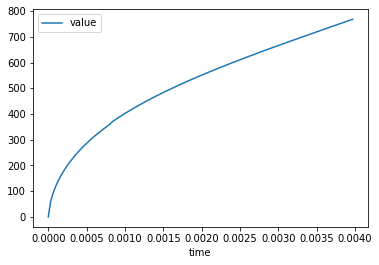

In [19]:
computing_psi_n(128).set_index('time').plot()

In [20]:
def c_1(n):
    return 2*n*(computing_psi_n(n).iloc[-1].value - computing_psi_n(2*n).iloc[-1].value)

In [21]:
c_1(2048)

t_k0= 0.000980437748015873
t_k0= 0.0010056268601190475


197.72918934142217

In [ ]:
c_1(4096*16) ## Is taking more that 61 minutes!! # I interrupted it!! Too long!!